In [1]:
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm
%matplotlib inline

In [2]:
plants_dir = 'data/PlantVillage/PlantVillage'
number_of_classes = sum([len(d) for r, d, files in os.walk(plants_dir)])
total_plants = sum([len(files) for r, d, files in os.walk(plants_dir)])
class_names = os.listdir(plants_dir)
healthy_classes = [plant for plant in class_names if 'healthy' in plant]
unhealthy_classes = list(set(class_names) - set(healthy_classes))
plant_files = []
classes = []
image_types = ['.PNG', '.png', '.JPG', '.jpg', '.JPEG', '.jpeg']
def load_plant_files(class_name):
    files = [files for r, d, files in os.walk(f'{plants_dir}/{class_name}')][0]
    return [f'{plants_dir}/{class_name}/{file}' for file in files if Path(file).suffix in image_types]
    
def load_classes(class_name):
    files = [files for r, d, files in os.walk(f'{plants_dir}/{class_name}')][0]
    return np.array([class_name for file in files if Path(file).suffix in image_types])

In [3]:
files = [file for class_name in class_names for file in load_plant_files(class_name)]
classes = [file for class_name in class_names for file in load_classes(class_name)]

In [4]:
len(files), len(classes)

(20638, 20638)

In [5]:
files[0], classes[0]

('data/PlantVillage/PlantVillage/Tomato_Septoria_leaf_spot/cc446d29-cb74-4c2d-b9c4-a08632ea045b___Matt.S_CG 7850.JPG',
 'Tomato_Septoria_leaf_spot')

data/PlantVillage/PlantVillage/Tomato_Early_blight/76b0d46d-8e2b-463b-8cba-eaeee6dc1851___RS_Erly.B 9527.JPG


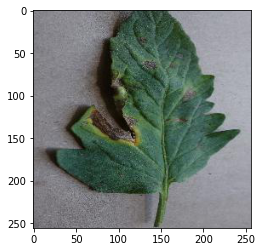

In [6]:
# show sample disease
img_num = 4573
img = plt.imread(files[img_num])
plt.imshow(img)
print(files[img_num])

In [7]:
# load data
train_images = []
for i in tqdm(range(len(files))):
    img = image.load_img(files[i], target_size=(80, 80, 3))
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)
X = np.array(train_images)

100%|██████████| 20638/20638 [00:24<00:00, 835.80it/s]


In [8]:
le = LabelEncoder()
le.fit(classes)
y = le.transform(classes)

In [9]:
y = to_categorical(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [15]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(80, 80, 3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
516/516 [==============================] - 157s 305ms/step - loss: 1.1538 - accuracy: 0.6422 - val_loss: 0.6877 - val_accuracy: 0.7762
Epoch 2/10
516/516 [==============================] - 169s 328ms/step - loss: 0.3822 - accuracy: 0.8787 - val_loss: 0.5458 - val_accuracy: 0.8183
Epoch 3/10
516/516 [==============================] - 171s 331ms/step - loss: 0.1707 - accuracy: 0.9449 - val_loss: 0.4139 - val_accuracy: 0.8668
Epoch 4/10
516/516 [==============================] - 171s 331ms/step - loss: 0.0832 - accuracy: 0.9749 - val_loss: 0.5554 - val_accuracy: 0.8391
Epoch 5/10
516/516 [==============================] - 174s 337ms/step - loss: 0.0568 - accuracy: 0.9834 - val_loss: 0.4991 - val_accuracy: 0.8624
Epoch 6/10
516/516 [==============================] - 175s 339ms/step - loss: 0.0493 - accuracy: 0.9841 - val_loss: 0.5667 - val_accuracy: 0.8629
Epoch 7/10
516/516 [==============================] - 172s 334ms/step - loss: 0.0329 - accuracy: 0.9898 - val_loss: 0.6233 -

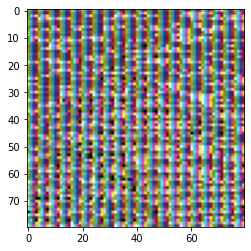

In [18]:
im1 = Image.fromarray(X_train[0], 'RGB')
plt.imshow(im1)

In [31]:
# Save the model
model.save("saved_models/plant_disease_classification")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/plant_disease_classification/assets


In [32]:
# testing the saved model
recon_model = load_model("saved_models/plant_disease_classification")

In [33]:
# test the model
np.testing.assert_allclose(
    recon_model.predict(X_test), recon_model.predict(X_test)
)

In [34]:
recon_model.fit(X_test, y_test)

129/129 [==============================] - 33s 258ms/step - loss: 0.5191 - accuracy: 0.8525


In [39]:
prediction = recon_model.predict(X_test[:1])

In [45]:
prediction.shape

(1, 15)

In [48]:
model.predict_classes(X_test[:3])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([12,  5, 11])

In [53]:
test_predictions = recon_model.predict_classes(X_test[:5])

In [55]:
test_pred_labels = le.inverse_transform(test_predictions)
test_pred_labels

array(['Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot',
       'Tomato__Target_Spot', 'Pepper__bell___Bacterial_spot',
       'Tomato__Tomato_YellowLeaf__Curl_Virus'], dtype='<U43')

In [ ]:
y.